## Boiler Plate:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Behind the scenes code:
import dreply_BMWit_source as dreply

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

height has been deprecated.



## What data are we analzing?
* We wanted to demonstrate data science on a BMW Carmen UK CRM dataset but were unable to procure that data
* Here, we analyze a dataset of **Warranty Claims in the USA between 2009 and 2012**
* Time permitting, demo will include topic recognition from scraped BMW forum data from [www.bimmerfest.com](www.bimmerfest.com)

## Parse and Load Warranty Claims Dataset
Libraries: Pandas, Regular Expressions

In [2]:
df = dreply.parse_and_load('../data/claims_full.txt')
df.head(3)

,pCLAIM_DEALER_GEOCODE,CLAIM_AGE_BUCKET,CLAIM_DEALER,CLAIM_DEALER_STATEPROVINCE,CLAIM_DATE,CLAIM_LABOR_CODE,CLAIM_LABOR_DESC,CLAIM_MONTH,CLAIM_PERIOD,CLAIM_QUARTER,...,pPART_HIST_COUNT,pPART_OPTIONS,pPART_PREVIOUSHIST,pPART_PREVIOUSHIST2,pPART_PREVIOUSHIST3,pPART_PREVIOUSHIST4,pPART_PREVIOUSHIST5,pVEH_EXPOSURE,pVEH_FLOAT,Days_In_Service
0,NaN,0 - 30 Days,NICHOLS DODGE,NC,2011-05-23,NaN,NaN,05 - MAY,2011-05,Q2,...,1,&LZE#&LZ4.,"2003/05/29,p313J1RLSXXKJ-1241,p313OPK1QJ5CA-31...",NaN,NaN,NaN,NaN,294,264,30
1,42.193400 -75.884900,91 - 180 Days,COREY'S NORTHGATE FORD/MADZA,NY,2010-09-15,NaN,NaN,09 - SEP,2010-09,Q3,...,1,&LZ4.,"2003/05/29,p313J1RLSXXKJ-1241,p313OPK1QJ5CA-31...",NaN,NaN,NaN,NaN,104,239,12
2,39.066700 -77.599700,91 - 180 Days,"DULLES MOTORCARS ~ JEEP, KIA, AND SUBARU",VA,2010-11-22,NaN,NaN,11 - NOV,2010-11,Q4,...,1,&LS4.,"2004/03/01,p313P805IXCRB-1900,p313B26QCG3KA-10...",NaN,NaN,NaN,NaN,308,159,148


## What kind of data is here?:

In [3]:
dreply.summarize(df)

pCLAIM_DEALER_GEOCODE          object
CLAIM_DEALER                   object
CLAIM_DEALER_STATEPROVINCE     object
CLAIM_DATE                     object
CLAIM_LABOR_CODE               object
Commodity                      object
Complaint_Description          object
PROD_DATE                      object
Part_Number                    object
RecordID                       object
SALE_DATE                      object
Supplier_Location              object
Vehicle_Assembly_Plant         object
Vehicle_Float                  object
Vehicle_Make                   object
Vehicle_Manufacturer           object
Vehicle_Model                  object
Vehicle_Model_Year              int64
pCLAIM_AGE_BUCKET             float64
pCLAIM_ODMTR_MILEAGE            int64
pCLAIM_TOT_GLOBL_AMT          float64
Days_In_Service                 int64
dtype: object

## Traditional Data Analysis and Visualization with Structured Data:
Some tools include:
* Tableau
* QLik
* Oracle - big data discovery
* **Python** - matplotlib, seaborn, *etc.*
* R - ggplot

## A Few Basic Drill Downs
#### This is the type of stuff that business analysts can already do easily with structured data

## Example 1: Number of Claims by Year:

In [4]:
df1 = df.groupby(['CLAIM_YEAR','Vehicle_Make']).apply(lambda x: len(x))
df1

CLAIM_YEAR  Vehicle_Make        
2009        ACURA                      3
            AMERICAN IRONHORSE         1
            AUDI                     258
            BMW                       99
            BUICK                     10
            CADILLAC                  15
            CHEVROLET               1648
            CHRYSLER                 142
            COACHMEN                   1
            COLUMBIA                   1
            DAMON                      1
            DODGE                    507
            FLEETWOOD                  3
            FORD                    1083
            FOREST RIVER               1
            FREIGHTLINER               3
            GEO                        1
            GM                         1
            GMC                       25
            HARLEY DAVIDSON            2
            HONDA                     42
            HUMMER                     3
            HYUNDAI                   20
            IC          

## Example 2: Claims in 2012 by Vehicle Make:

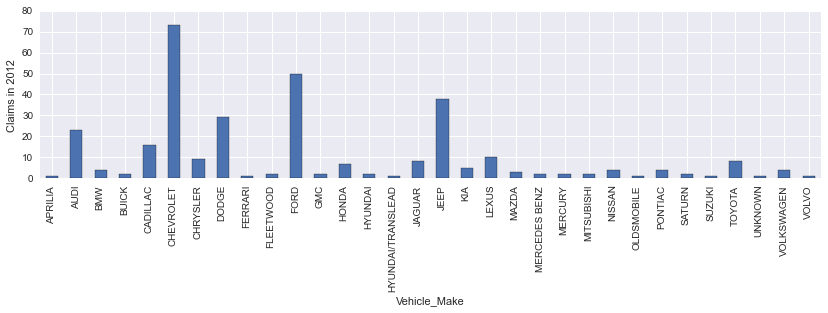

In [5]:
df1[2012].plot('bar', figsize=(14,3))
plt.ylabel('Claims in 2012')

## Example 3: BMW Claims Time Series:

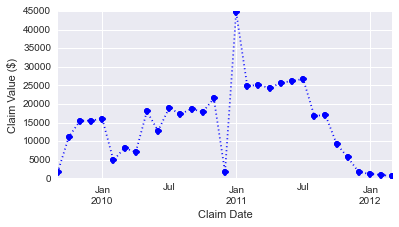

In [7]:
df['cdate'] = pd.to_datetime(df.CLAIM_DATE)
(df[df.Vehicle_Make=='BMW']
    .set_index('cdate')
    .pCLAIM_TOT_GLOBL_AMT
    .resample('M', how='sum')
    .plot(style='b:', marker='o', figsize=(6,3))
)
plt.xlabel('Claim Date')
plt.ylabel('Claim Value ($)')

## Example 4: Top 10 BMW Claim Reasons:

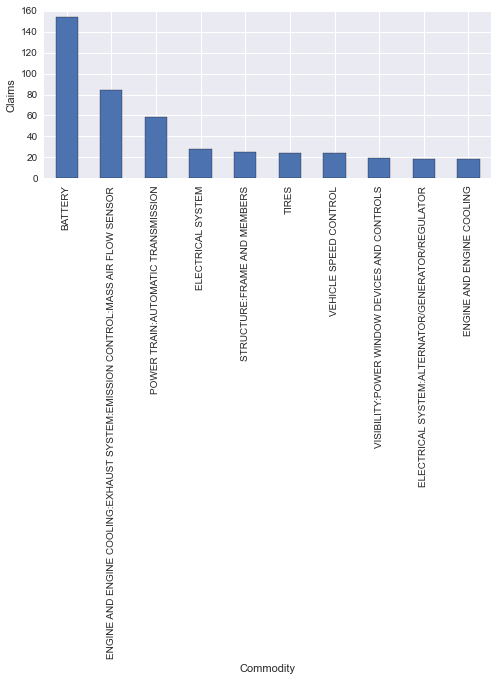

In [7]:
(df.groupby(['Vehicle_Make','Commodity'])
 .apply(lambda x: len(x))['BMW']
 .order(ascending=False)[:10]
 .plot('bar', figsize=(8,3))
)
plt.ylabel('Claims')

## Why not build a claim value predictor?
* On what variables does claim value depend upon?
* **Train model to estimate the dollar value of a claim based variables discovered above**

## Before model "feature selection," we need to first transform data:
* Most datatypes are categorical and need to be vectorized

In [8]:
df, covariates, state_to_reg_series, makes = dreply.transform_vectorize(df)
df_BMW = df[df.Vehicle_Make=='BMW']

## Obviously Claim Value Depends On Claim Issue:

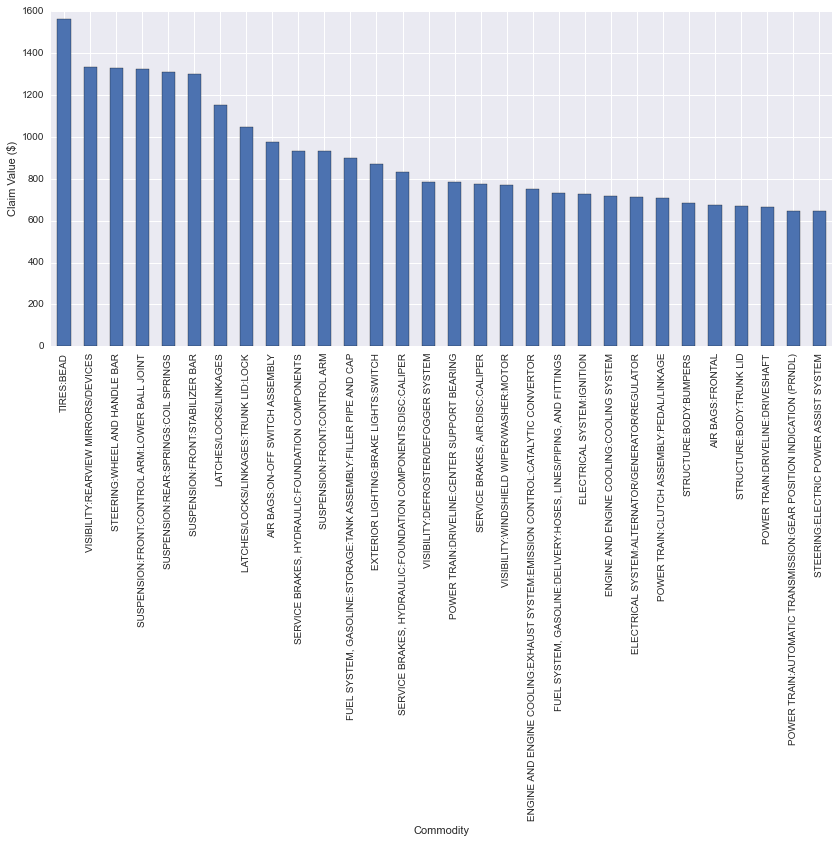

In [9]:
values = df_BMW.groupby('Commodity').mean()['pCLAIM_TOT_GLOBL_AMT'].sort(ascending=False, inplace=False)
values[:30].plot('bar', figsize=(14,6))
plt.ylabel('Claim Value ($)')

## Can We Predict The Claim Value Based On Car Age and Type??
#### Let's look at the BMW models with the most claim data in order to make a prediction

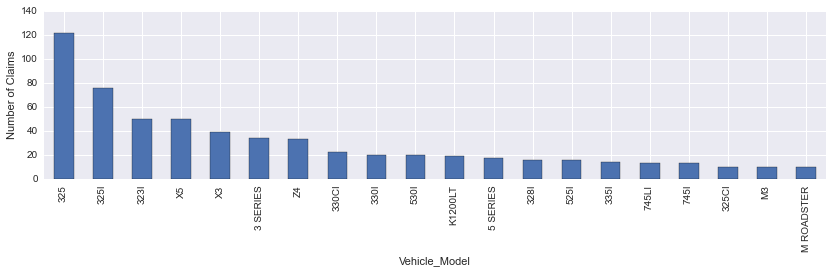

In [10]:
BMW_Claims = (df_BMW.groupby('Vehicle_Model')
              .apply(lambda x: len(x))
              .sort(inplace=False, ascending=False)
              )
BMW_Claims[:20].plot('bar', figsize=(14,3))
plt.ylabel('Number of Claims')

## Given enough data, one can predict the warrenty claim value over the age of the vehicle!

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


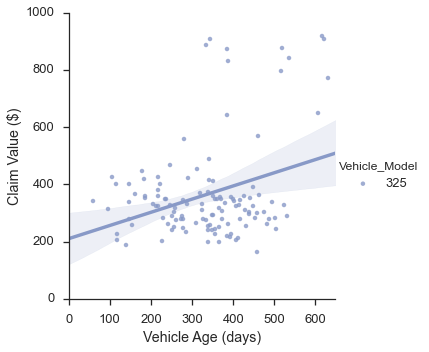

In [11]:
dreply.lmplot(df_BMW[df_BMW.Vehicle_Model.isin(BMW_Claims[0:1].index)], 
              size=5, xlim=(0,650), ylim=(0,1000))

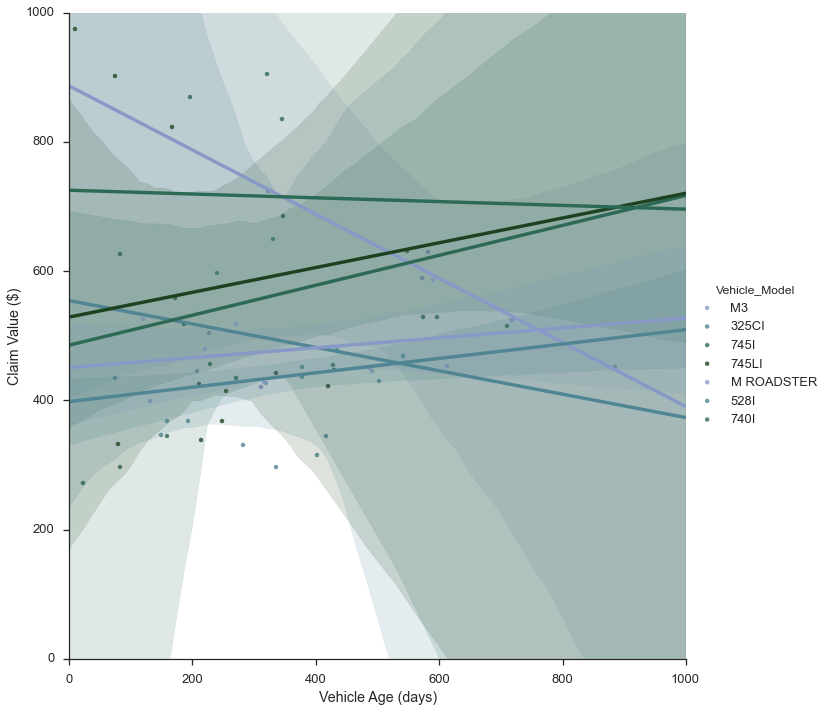

In [12]:
dreply.lmplot(df_BMW[df_BMW.Vehicle_Model.isin(BMW_Claims[15:22].index)], 
              size=10, xlim=(0,1000), ylim=(0,1000))

* Use these models to back-predict when particular problems are likely to occur next and get ahead of them
* Use these models to predict the expected lifetime warranty expenses by vehicle type
* Use these models to predict the warranty expenses of similar vehicles types

## Other Data Science:
#### Cluster like warranties together to better understand what is happening
E.G.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


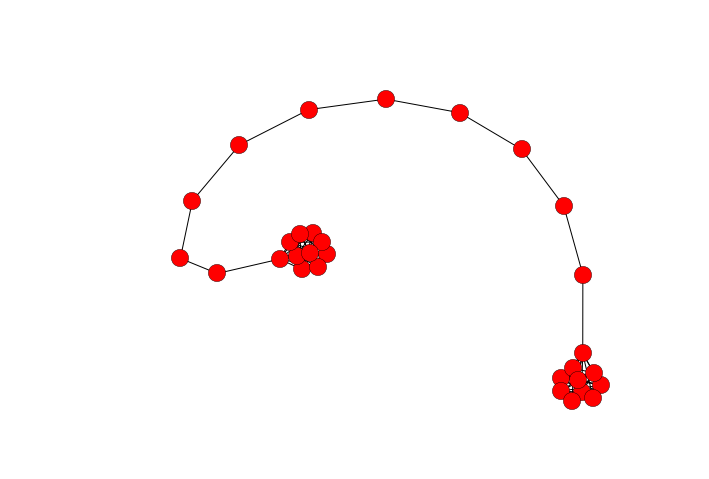

In [13]:
import networkx as nx
plt.figure(figsize=(9,6))
Gbarbell = nx.barbell_graph(10,10) # This is an unweighted graph
nx.draw(Gbarbell)

## Geocoding:
#### One might be interested in knowing where certain claims tend to happen, to optimize response

* In the dataset, we have Dealer Geolocations (Lat,Lng) and US state
* Some US states missing, if we had those, we could map the data into US Federal regions:
![US Federal Regions](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/USFederalRegions.svg/220px-USFederalRegions.svg.png)

In [14]:
print "MISSING STATE-DATA:"
missing_geo_entries = (df.pCLAIM_DEALER_GEOCODE.notnull() &
                       df.CLAIM_DEALER_STATEPROVINCE.isnull())
df.ix[missing_geo_entries, ['pCLAIM_DEALER_GEOCODE', 'CLAIM_DEALER_STATEPROVINCE']].head(3)

MISSING STATE-DATA:


,pCLAIM_DEALER_GEOCODE,CLAIM_DEALER_STATEPROVINCE
1323,36.622100 -121.821700,NaN
9085,39.774500 -86.109600,NaN
28557,33.448600 -112.073300,NaN


## Reverse Geocode to Recover State:

In [15]:
df.ix[missing_geo_entries, 'pCLAIM_DEALER_GEOCODE'] = \
    df.ix[missing_geo_entries, 'pCLAIM_DEALER_GEOCODE'].map(dreply.reverseGEO)

(36.622100 -121.821700) --> california
(39.774500 -86.109600) --> indiana
(33.448600 -112.073300) --> arizona
(33.736000 -117.818500) --> california
(40.791800 -73.775900) --> new york
(37.825700 -82.045000) --> west virginia
(43.116100 -89.537500) --> wisconsin
(28.829600 -82.255300) --> florida
(36.725600 -91.912300) --> missouri
(45.490800 -122.804600) --> oregon


## What's around?  
#### Recommend a place for the customer to visit while waiting for repairs at dealer
Possible GET calls to:
* Yelp API
* Google Places API
* **Here Maps API**
* Foursquare API
* *etc.*

In [16]:
latlng = '36.153889 -95.992500'
nearby_places = dreply.places_nearby(latlng)
dreply.places_nearby_statement(nearby_places, closer_than=1000)

DEALER ADDRESS: 
183 W 2nd St S
Tulsa, OK 74103
USA

NEARBY LOCATIONS within 1000m:
1. 254m away, <here>, there is a theatre-music-culture (store)
2. 830m away, <here>, there is a theatre-music-culture (store)
3. 486m away, <here>, there is a restaurant (store)
4. 164m away, <here>, there is a theatre-music-culture (store)
5. 436m away, <here>, there is a coffee-tea (store)
6. 133m away, <here>, there is a restaurant (store)
7. 899m away, <here>, there is a restaurant (store)
8. 566m away, <here>, there is a restaurant (store)
9. 501m away, <here>, there is a snacks-fast-food (store)
10. 321m away, <here>, there is a snacks-fast-food (store)
11. 136m away, <here>, there is a restaurant (store)
12. 218m away, <here>, there is a restaurant (store)


In [ ]:
# To dos: HereMap embed in ipython, real graph maybe?

## Presentation Points:
* Upcoming data analysts use open source (accessible) software to do analysis and science
  * Huge community doing this 
* 
* Relatively seemless scaling
  * KAFKA
  * Spark MLlib 


1. scalability
1. production - realtime
1. cost
1. data analysis flexibility
1. community
1. mindset - distributability of code
1. holy grail - easy tools